In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from scipy.optimize import differential_evolution

from numba import njit

In [2]:
#colors
DARK_RED = '#b30000'
RED = '#ff0000'
GRAY = '#bfbfbf'
BLUE = '#4d94ff'
DARK_BLUE = '#0066ff'

## Links
- Media Sources by Dem/Rep: https://www.journalism.org/2020/01/24/americans-are-divided-by-party-in-the-sources-they-turn-to-for-political-news/
- Most common platform for news by Dem/Rep: https://www.journalism.org/2020/01/24/election-news-pathways-project-frequently-asked-questions/#ideological-composition-of-news-outlets-audiences
- News from social media 2021: https://www.pewresearch.org/fact-tank/2021/01/12/more-than-eight-in-ten-americans-get-news-from-digital-devices/
- Number of sources by Dem/Rep: https://www.pewresearch.org/pathways-2020/MAINSOPOL_USE/political_party/us_adults
- News from social media 2020: https://www.journalism.org/2020/07/30/americans-who-mainly-get-their-news-on-social-media-are-less-engaged-less-knowledgeable/
- Most common platform by Dem/Rep: https://www.pewresearch.org/pathways-2020/NEWS_MOST/political_party/us_adults
- Paper about Social Media and news consumption: https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.20191777
- Daily news consumption: https://www.americanpressinstitute.org/publications/reports/survey-research/americans-news-consumption/

In [16]:
@njit(nogil=True)
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]
        
@njit(nogil=True)
def optimize_step(steps, agent_approval_values, num_agents, agent_approvals, consumption_rates,media_choices, uses_social_media, agent_late_night, agent_anti_late_night, approval_types, neg_persuadability, pos_persuadability,
                  threshold=0.15, alpha=0.01, persuadability_scale=10, coverage_leaning=0.5, social_media_const=0.1, 
                  late_night_const=-1, late_night_jokes=0, use_late_night=True, contributions=np.array([])):
    if len(contributions) == 0:
        contrib = False
        media_array = np.zeros((0, ))
    else:
        contrib = True
        media_array = np.zeros((27, ))
    
    agent_storage = np.zeros((steps+1, 2, num_agents))
    agent_storage[0, 0] = agent_approval_values.copy()
    i = 0
    for a in agent_approvals:
        if a == approval_types[0]:
            agent_storage[0, 1, i] = 0
        elif a == approval_types[1]:
            agent_storage[0, 1, i] = 1
        elif a == approval_types[2]:
            agent_storage[0, 1, i] = 2
        elif a == approval_types[3]:
            agent_storage[0, 1, i] = 3
        elif a == approval_types[4]:
            agent_storage[0, 1, i] = 4

        i += 1
    
    #agent_approval_values = starting_state
    media_values = np.array([1, 0.5, -0.5, -1, 0])
    polling_history = np.zeros((steps, 2))
    for current_step in range(steps):
        for i in range(num_agents):
            second_rate = 0
            rate = 0
            if consumption_rates[i] < 1:
                rate = consumption_rates[i]
            elif consumption_rates[i] > 1:
                rate = 1
                second_rate = consumption_rates[i] - 1

            will_consume = rand_choice_nb(np.array([True, False]), np.array([rate, 1-rate]))

            while will_consume:
                value = media_choices[i][current_step]
                if value is None: break

                kernel = value + coverage_leaning - agent_approval_values[i]
                if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                    if value > 0:
                        neg_persuadability[i] -= abs(kernel) * persuadability_scale
                        if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                        if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                    elif value < 0:
                        pos_persuadability[i] -= abs(kernel) * persuadability_scale
                        if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                        if pos_persuadability[i] > 1: pos_persuadability[i] = 1
                elif value != 0:
                    p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                    agent_approval_values[i] += p*kernel*alpha
                    if contrib:
                        media_array[int(contributions[i][current_step])] += p*kernel*alpha
                will_consume = rand_choice_nb(np.array([True, False]), np.array([second_rate, 1-second_rate]))

            if uses_social_media[i]:
                p = pos_persuadability[i] if agent_approval_values[i] > 0 else neg_persuadability[i]
                x = np.abs(agent_approval_values[i])
                const = np.exp(-np.exp(1)*x) * social_media_const#(1-x)/(2*x+1)
                #const *= social_media_const
                agent_approval_values[i] += np.sign(agent_approval_values[i])*const * p
                if contrib:
                        media_array[-1] += np.sign(agent_approval_values[i])*const * p

                
            if use_late_night:
                #arbitrary percents from 0 to 6
                percents = [0, 0.8/30, 2/30, 1/10, 2/7, 4/7]

                #also arbitrary amount?
                #value = late_night_const
                if rand_choice_nb(np.array([True, False]), np.array([percents[agent_late_night[i]], 1-percents[agent_late_night[i]]])):
                    kernel = (late_night_const * late_night_jokes) - agent_approval_values[i]
                    value = (late_night_const * late_night_jokes)
                    if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
                        if value > 0:
                            neg_persuadability[i] -= abs(kernel) * persuadability_scale
                            if neg_persuadability[i] < 0: neg_persuadability[i] = 0
                            if neg_persuadability[i] > 1: neg_persuadability[i] = 1
                        elif value < 0:
                            pos_persuadability[i] -= abs(kernel) * persuadability_scale
                            if pos_persuadability[i] < 0: pos_persuadability[i] = 0
                            if pos_persuadability[i] > 1: pos_persuadability[i] = 1

                    else:#if value != 0:
                        p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
                        agent_approval_values[i] += p*kernel*alpha
                        if contrib:
                            media_array[-2] += p*kernel*alpha
                        
                        
                
                #ANTI-LATENIGHT
                #value = -late_night_const
#                 if rand_choice_nb(np.array([True, False]), np.array([percents[agent_anti_late_night[i]], 1-percents[agent_anti_late_night[i]]])):
#                     kernel = (-late_night_const * late_night_jokes) - agent_approval_values[i]
#                     value = (-late_night_const * late_night_jokes)
#                     if np.sign(value) == np.sign(agent_approval_values[i]) and abs(value) < abs(agent_approval_values[i]):
#                         if value > 0:
#                             neg_persuadability[i] -= abs(kernel) * persuadability_scale
#                             if neg_persuadability[i] < 0: neg_persuadability[i] = 0
#                             if neg_persuadability[i] > 1: neg_persuadability[i] = 1
#                         elif value < 0:
#                             pos_persuadability[i] -= abs(kernel) * persuadability_scale
#                             if pos_persuadability[i] < 0: pos_persuadability[i] = 0
#                             if pos_persuadability[i] > 1: pos_persuadability[i] = 1

#                     else:#if value != 0:
#                         p = pos_persuadability[i] if kernel > 0 else neg_persuadability[i]
#                         agent_approval_values[i] += p*kernel*alpha
#                         if contrib:
#                             media_array[-3] += p*kernel*alpha

            w = np.where((agent_approval_values[i] < (media_values + threshold)) & (agent_approval_values[i] > (media_values - threshold)))[0]

            if len(w):
                agent_approvals[i] = approval_types[w][0]
                
        agent_storage[current_step+1, 0] = agent_approval_values.copy() 
        i = 0
        for a in agent_approvals:
            if a == approval_types[0]:
                agent_storage[current_step+1, 1, i] = 0
            elif a == approval_types[1]:
                agent_storage[current_step+1, 1, i] = 1
            elif a == approval_types[2]:
                agent_storage[current_step+1, 1, i] = 2
            elif a == approval_types[3]:
                agent_storage[current_step+1, 1, i] = 3
            elif a == approval_types[4]:
                agent_storage[current_step+1, 1, i] = 4
            
            i += 1
        
        approve = 0
        disapprove = 0
        no_opinion = 0
        for i in range(num_agents):
            if agent_approvals[i] == approval_types[0] or agent_approvals[i] == approval_types[1]:
                approve += 1
            elif agent_approvals[i] == approval_types[2] or agent_approvals[i] == approval_types[3]:
                disapprove += 1
            else:
                no_opinion += 1
        polling_history[current_step] = [100*approve/num_agents, 100*disapprove/num_agents]
    
    
    return polling_history, media_array, agent_storage#, 100*no_opinion/num_agents]

In [17]:
#make media classes
class MediaOutlet:
    def __init__(self, name, political_leaning, mcb_ideology):#, mcb_education, mcb_age)
        self.name = name
        self.political_leaning = political_leaning #negative is left, pos is right
        
        #Media Consumption by...
        self.mcb_ideology = mcb_ideology#[dem, Dlean, Rlean, rep]  % of that group that consumes

    def __str__(self):
        return self.name
     
    def get_value(self):
        return self.political_leaning    
    

In [18]:
#make agent class
class Agent:
    def __init__(self, approval, ideology, approval_value):
        self.assigned_media_sources = []
        self.consumption_rate = 0

        #demographic information
        self.approval = approval
        self.ideology = ideology
        
        self.approval_value = approval_value
        
        #using this set up gives us a steeper curve than above and also accounts for values outside of the bounds -1, 1
            #at 0 the persuadability is 0.269 rather then 0.5
        denom = np.exp(2)-1
        self.neg_persuadability = (np.exp(-approval_value+1)-1)/denom
        self.pos_persuadability = (np.exp(approval_value+1)-1)/denom
        
        self.uses_social_media = False
        
        self.late_night = 0
        self.anti_late_night = 0
       
    
    def assign(self, media_outlet):
        self.assigned_media_sources.append(media_outlet)
        
        
    def stats(self):
        print(f'Ideology: {self.ideology}\nApproval: {self.approval}')

        print('\tMedia Sources: ', end='')
        for m in self.assigned_media_sources:
            print(m, end=', ')
        
        print(f'\n\tConsumption Frequency: {self.consumption_rate}', end='')
        
        oftenness = ['Never', 'Less than Once a Month', 'About Once a Month', 'Several Times a Month', 'Once a Week', 'Multiple Times A Week']
        print(f'\nWatches Late-Night: {oftenness[self.late_night]}')
            
    def consume_media(self):
        #return all the media bias values 
        return [m.get_value() for m in self.assigned_media_sources]

In [19]:
class Model:
    def __init__(self, num_agents, political_distribution, approval_matrix, media_array, distribution_threshold=0.1, platform_split=[[], []], use_late_night=False, use_anti_late_night=False):
                                                                                                                    # %dem, %rep who use social media for news
        self.political_distribution = political_distribution 
            #[%, %, %] (for now, [D, R, indep])distrib of agents ideologies
            
        self.approval_matrix = np.array(approval_matrix)
        
            #[Dem, Rep, Ind] by [strongly app, somewhat app, somewhat disapp, strongly disapp, no approval]
                #matrix 
        
        self.media_array = media_array 
            #array of MediaOutlet objects to loop through
        
        self.platform_split = platform_split
        # %dem, %rep who use social media for news
        
        self.use_late_night = use_late_night
        self.use_anti_late_night = use_anti_late_night
        #make the agents
        self.agents = [None]*num_agents
        self.agent_approval_values = np.zeros((num_agents, ))
        self.generate_agents(num_agents, distribution_threshold)
        
        self.starting_state = self.agent_approval_values.copy()
        self.starting_agent_op = [str(agent.approval) for agent in self.agents]
        
        
    def generate_agents(self, num_agents, distribution_threshold):
        #initialize agents with ideology and approval
            #approval is a continuous value normally distributed around the 4 poles within some threshold
        
        
        distribution = np.round(self.approval_matrix * self.political_distribution * num_agents / 10000)
        
        #account for rounding errors to meet the target distribution
        target = [.44, .52] #app, dis
        approvals = np.sum(distribution, axis=1)
        a = (approvals[0] + approvals[1])/len(self.agents)
        d = (approvals[2] + approvals[3])/len(self.agents)
        
        need_app = np.round((target[0] * num_agents) - (a * num_agents))
        need_dis = np.round((target[1] * num_agents) - (d * num_agents))
        
        #add approval evenly across strongly and somehwat approve and over all party types
        distribution[:2, :] += need_app//6
        distribution[2:4, :] += need_dis//6
        
        #just assign any extra agents randomly in the middle
        other = num_agents-np.sum(distribution, dtype=int)
        approval_choice = np.random.choice([1, 2, 4], other)
        party_choice = np.random.choice([0, 1, 2], other)
        for i in range(other): distribution[approval_choice[i], party_choice[i]] += 1
        
        current_agent = 0
        approval_types = ['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion']
        self.approval_types = np.array(approval_types)
        #approval_values = [1, 0.5, -0.5, -1, 0]
        
        pl = [abs(m.political_leaning) for m in self.media_array]
        m = max(pl)
        approval_values = [m, m/2, -m/2, -m, 0]
        party_types = ["democrat", 'republican', 'independent', 'lean republican', 'lean democrat']

        for index, approval_row in enumerate(distribution):
            for party_index, amount in enumerate(approval_row):
                amount = int(amount)
                self.agent_approval_values[current_agent:current_agent+amount] = np.random.uniform(approval_values[index]-distribution_threshold, approval_values[index]+distribution_threshold, (amount,))#np.random.normal(approval_values[index], distribution_threshold/3, (amount,)) 
                self.agents[current_agent:current_agent+amount] = [Agent(approval_types[index], party_types[party_index], self.agent_approval_values[current_agent+i]) for i in range(amount)]
                current_agent += amount

        self.assign_media()
        if self.use_late_night:
            self.assign_late_night()
            
        if self.use_anti_late_night:
            self.assign_anti_late_night()

            
            
    def assign_late_night(self):
        '''Watch Late Night? HR1_1 by PID
              Yes.   No
        Dem   54.    46
        Ind   34.    66
        Rep   26.    74


        How often? (Of those who said yes) HR2 by PID
              Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
        Dem.     51             18.           15.            5.               6.            5
        Ind      35.            17.           22.            10.              9.            7
        Rep      35.            18.           20             10               12            5
        '''
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        inds = np.where(pids == 'independent')[0]
        reps  = np.where(pids == 'republican')[0]

        #from above polling
        dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
        inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
        reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

        LN_dems = np.where(dems_watch_LN)[0]
        LN_inds = np.where(inds_watch_LN)[0]
        LN_reps = np.where(reps_watch_LN)[0]

        LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
        LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
        LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .18, .20, .10, .12, .05])

        for d in LN_dems: self.agents[d].late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
        for i in LN_inds: self.agents[i].late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
        for r in LN_reps: self.agents[r].late_night = LN_reps_watch_amount[list(LN_reps).index(r)]
            
    
    
    def assign_anti_late_night(self):
        '''Watch Late Night? HR1_1 by PID
              Yes.   No
        Dem   54.    46
        Ind   34.    66
        Rep   26.    74


        How often? (Of those who said yes) HR2 by PID
              Mult/week     Once/Week.    Mult/month.    Once/month.    < once/month.     Never
        Dem.     51             18.           15.            5.               6.            5
        Ind      35.            17.           22.            10.              9.            7
        Rep      35.            18.           20             10               12            5
        '''
        
        #switch democrats and republicans here
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'republican')[0]
        inds = np.where(pids == 'independent')[0]
        reps  = np.where(pids == 'democrat')[0]

        #from above polling
        dems_watch_LN = np.random.choice([True, False], len(dems), p=[.54, .46])
        inds_watch_LN = np.random.choice([True, False], len(inds), p=[.34, .66])
        reps_watch_LN = np.random.choice([True, False], len(reps), p=[.26, .74])

        LN_dems = np.where(dems_watch_LN)[0]
        LN_inds = np.where(inds_watch_LN)[0]
        LN_reps = np.where(reps_watch_LN)[0]

        LN_dems_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_dems), p=[.51, .18, .15, .05, .06, .05])
        LN_inds_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_inds), p=[.35, .17, .22, .10, .09, .07])
        LN_reps_watch_amount = np.random.choice([5, 4, 3, 2, 1, 0], len(LN_reps), p=[.35, .18, .20, .10, .12, .05])

        for d in LN_dems: self.agents[d].anti_late_night = LN_dems_watch_amount[list(LN_dems).index(d)]
        for i in LN_inds: self.agents[i].anti_late_night = LN_inds_watch_amount[list(LN_inds).index(i)]
        for r in LN_reps: self.agents[r].anti_late_night = LN_reps_watch_amount[list(LN_reps).index(r)]


    
    def assign_media(self):
        '''
        There is nuance in the four way split of consumption, but there is no data about the 
        '''
        pids = np.array([agent.ideology for agent in self.agents])
        dems = np.where(pids == 'democrat')[0]
        reps  = np.where(pids == 'republican')[0]

        dems_to_consume = np.array([int(np.round(media.mcb_ideology[0] * len(dems) / 100)) for media in self.media_array])
        reps_to_consume = np.array([int(np.round(media.mcb_ideology[-1] * len(reps) / 100)) for media in self.media_array])
        
        for i, agent in enumerate(self.agents):
            if i in dems:
                p = dems_to_consume/np.sum(dems_to_consume)
                index = rand_choice_nb(np.arange(len(self.media_array)), p)
                dems_to_consume[index] -= 1
                agent.assign(self.media_array[index])
            elif i in reps:
                p = reps_to_consume/np.sum(reps_to_consume)
                #choice = np.random.choice(self.media_array, p=p)
                index = rand_choice_nb(np.arange(len(self.media_array)), p)
                reps_to_consume[index] -= 1
                agent.assign(self.media_array[index])
            else:
                index = np.random.randint(0, len(self.media_array))#rand_choice_nb(np.arange(len(self.media_array)), p)
                reps_to_consume[index] -= 1
                agent.assign(self.media_array[index])
        
        #Social Media        
        to_consume = [0, 0]
        to_consume[0] = int(np.round(self.platform_split[0][1] * len(dems) / 100))
        to_consume[1] = int(np.round(self.platform_split[1][1] * len(reps) / 100))
        dem_agent_indices = np.random.choice(dems, size=to_consume[0], replace=False)
        rep_agent_indices = np.random.choice(reps, size=to_consume[1], replace=False)
        
        for ind in dem_agent_indices:
            self.agents[ind].uses_social_media = True
        for ind in rep_agent_indices:    
            self.agents[ind].uses_social_media = True   
            
        
        
        #Consumption Rate
        '''
        Those that closely read an article or watch a program
        More    Once    Less    Never     in a day
        39% 	29% 	30% 	2%
         |       |       |      |
         V       V       V      V
        1.5      1       .5     0         percentages * 100        
        '''
        rates = np.random.choice([1.5, 1, 0.5, 0], len(self.agents), p=[.39, .29, .3, .02])

        for ind, r in enumerate(rates):
            self.agents[ind].consumption_rate = r
            
        
        
    
    def media_landscape(self):
        #describe how the media outlets inputted are distributed politcally and how many people watch them
        #x is leaning, y is number of agents that use it
        
        plt.figure(figsize=(15, 10))
        y = np.zeros((len(self.media_array), ))
        
        for agent in self.agents:
            for media in agent.assigned_media_sources:
                y[self.media_array.index(media)] += 1
            
        biases = [media.get_value() for media in self.media_array]
        for i in range(len(self.media_array)):
            plt.scatter(biases[i], y[i])
            plt.text(biases[i]+0.03, y[i]+0.03, self.media_array[i].name)
       #plt.subplot(121)
        #plt.bar(range(len(self.media_array)), y, label=[media.name for media in self.media_array])
        #plt.xticks(ticks=range(len(self.media_array)), labels=[media.name for media in self.media_array], rotation='vertical')
        plt.xlabel("Bias")
        plt.ylabel("Audience Size")

        plt.show()
        print('Mean of Biases:', np.mean(biases))
        print('Number of Sources:', len(self.media_array))
        print('Aggregate Score:', np.sum(biases*y)/len(self.agents))
        
        

In [20]:
                    '''political_leaning, mcb_ideology'''
CNN = MediaOutlet("CNN", -8.98, [57, 50, 32, 19])
MSNBC = MediaOutlet("MSNBC", -13.94, [38, 30, 17, 12])
HuffPost = MediaOutlet("HuffPost", -11.0, [18, 8, 3, 3])

NBC = MediaOutlet("NBC", -7.42, [39, 40, 32, 25])
ABC = MediaOutlet("ABC", -4.65, [32, 42, 36, 26])
CBS = MediaOutlet("CBS", -3.49, [30, 36, 29, 24])


WashingtonPost = MediaOutlet("Washington Post", -7.82, [33, 20, 9, 8])
NewYorkTimes = MediaOutlet("New York Times", -8.19, [42, 22, 12, 8])
Politico = MediaOutlet("Politico", -6.9, [20, 9, 6, 5])
Time = MediaOutlet("Time", -9.72, [11, 9, 5, 3])
TheGuardian = MediaOutlet("The Guardian", -9.77, [13, 4, 4, 3])


NPR = MediaOutlet("NPR", -4.94, [43, 20, 13, 9])
BBC = MediaOutlet("BBC", -2.67, [29, 16, 13, 8])
WallStreetJournal = MediaOutlet("Wall Street Journal", 4.93, [17, 13, 11, 11])
USAToday = MediaOutlet("USA Today", -4.0, [12, 14, 12, 8])
TheHill = MediaOutlet("The Hill", -0.5, [11, 5, 4, 5])
Newsweek = MediaOutlet("Newsweek", -6.28, [8, 7, 4, 3])

NewYorkPost = MediaOutlet("New York Post", 12.75, [5, 5, 4, 6])
WashingtonExaminer = MediaOutlet("WashingtonExaminer", 15.04, [1, 2, 3, 4])

FoxNews = MediaOutlet("Fox News", 14.67, [15, 29, 46, 68])
Hannity = MediaOutlet("Hannity", 23.44, [1, 1, 7, 27])
Limbaugh = MediaOutlet("Limbaugh", 25.98, [0.5, 1, 6, 23])
Breitbart = MediaOutlet("Breitbart", 17.11, [0.5, 1, 3, 11])
DailyCaller = MediaOutlet("Daily Caller", 16.29, [0.5, 1, 2, 5])


media_outlets = [CNN, MSNBC, HuffPost, #BuzzFeed, Vox, 
                 NBC, ABC, CBS, WashingtonPost, NewYorkTimes, Politico, Time, TheGuardian, 
                 NPR, BBC, WallStreetJournal, USAToday, TheHill, Newsweek, 
                 FoxNews, Hannity, NewYorkPost, WashingtonExaminer, 
                 Limbaugh, Breitbart, DailyCaller]

pl = [abs(m.political_leaning) for m in media_outlets]
cur_mean = np.mean(pl)
cur_std = np.std(pl)
cur_max = max(pl)
cur_min = min(pl)

a = -1
b = 1
for outlets in media_outlets:
#     val = a + ((outlets.political_leaning - cur_min)*(b-a))/(cur_max - cur_min)
#     outlets.political_leaning = val
    #outlets.political_leaning /= cur_mean
    outlets.political_leaning /= cur_max - cur_min

    


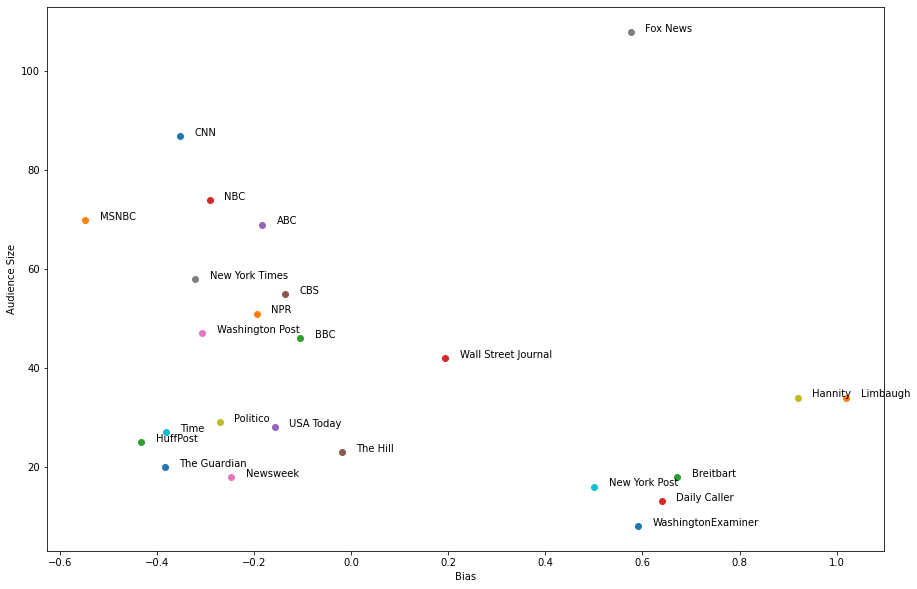

Mean of Biases: 0.03260727367870225
Number of Sources: 24
Aggregate Score: -0.03492817896389326


In [21]:
''' total = [44, 52, 4]
3/18/20 Ipsos poll [44, 37, 10],
[[5, 56, 14],
[8, 30, 23],
[18, 7, 21],
[67, 5, 32],
[2, 1, 10]]
'''

#28, 30, 28+13+2
model = Model(1000, [44, 37, 10],
                [[5, 56, 14],
                [8, 30, 23],
                [18, 7, 21],
                [67, 5, 32],
                [2, 1, 10]], 
              media_outlets, distribution_threshold=0.25, platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], 
              use_late_night=True)

''' total = [42, 52, 6]
4/22/20 Ipsos poll [44, 37, 10],
[[3, 54, 17],
[6, 26, 17],
[14, 6, 17],
[73, 7, 39],
[4, 7, 10]]
'''

''' total = [41, 54, 5]
5/20/20 Ipsos poll [44, 37, 10],
[[4, 55, 12],
[4, 27, 20],
[11, 6, 17],
[76, 7, 34],
[5, 5, 17]]
'''

model.media_landscape()

In [334]:
r = np.random.randint(1000)
model.agents[r].stats()
model.agents[r].consume_media()

Ideology: democrat
Approval: somewhat disapprove
	Media Sources: ABC, 
	Consumption Frequency: 0.5
Watches Late-Night: Never


[-0.1824960753532182]

In [305]:
max([a.approval_value for a in model.agents])

1.2692866828781897

In [22]:
media_names = [m.name for m in media_outlets]
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = [ 0.01877369,  0.07156605,  0.82809562,  1.30110476, -0.31278901]
late_night_jokes = 4.202088452088452
coverage_leaning = 0.05

m = Model(*args, distribution_threshold=0.25,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True, use_anti_late_night=True)

steps = 30
starting_state = m.starting_state.copy()
num_agents = len(m.agents)

approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


media_choices = np.zeros((num_agents, steps))
media_contributions = np.zeros((num_agents, steps))
agent_approvals = []
consumption_rates = np.zeros((num_agents, ))
uses_social_media = []
agent_late_night = []
neg_persuadability = np.zeros((num_agents,))
pos_persuadability = np.zeros((num_agents,))
agent_anti_late_night = []

denom = np.exp(2)-1
for i, agent in enumerate(m.agents):
    agent_approvals.append(agent.approval)
    consumption_rates[i] = agent.consumption_rate
    uses_social_media.append(agent.uses_social_media)
    agent_late_night.append(agent.late_night)
    agent_anti_late_night.append(agent.anti_late_night)
    neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
    pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
    if len(agent.consume_media()) == 0:
        media_choices[i] = np.array([None]*steps)
        media_contributions[i] = np.array([None]*steps)
    else:
        #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
        sources = np.array(agent.assigned_media_sources)
        values = np.array(agent.consume_media())
        choices = np.random.randint(0, len(sources), (steps,))
        media_choices[i] = values[choices]
        
        
        
        media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]
        
result, media_array, storage = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), 
              np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
              threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
              late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)

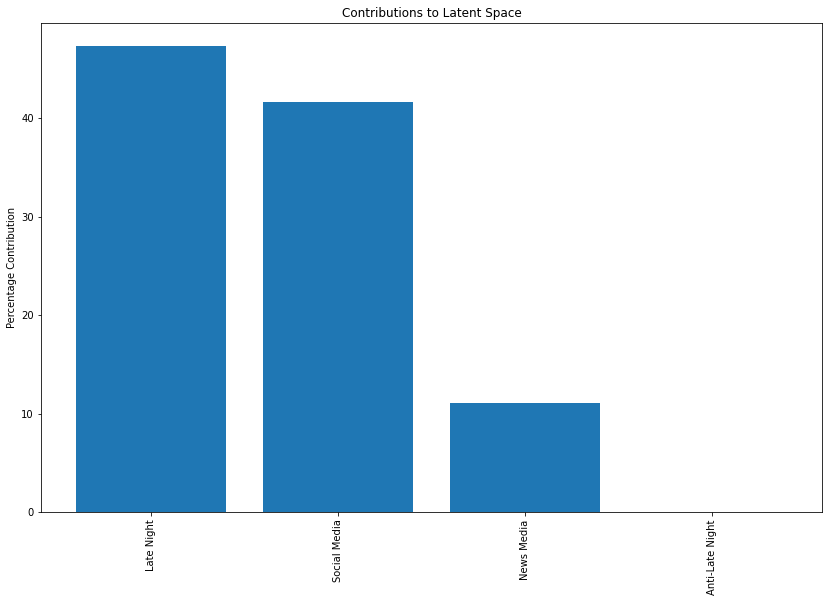

In [23]:
plt.figure(figsize=(14, 9))
media_array = np.abs(np.concatenate((np.array(np.sum(media_array[:-3])).reshape(-1, ), media_array[-3:])))
media_array = media_array/np.sum(media_array)
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(['News Media', 'Anti-Late Night', 'Late Night', 'Social Media'])#media_names+['Anti-Late Night', 'Late Night', 'Social Media'])
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

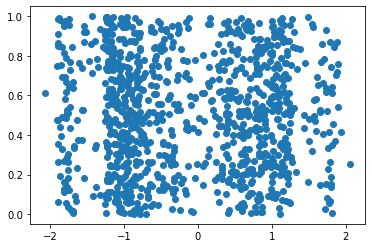

In [318]:
from time import sleep
for i in range(len(storage)):
    
    plt.scatter(storage[i, 0, :], np.random.uniform(size=1000))#, storage[i, 1, :])
    plt.show()
    
    clear_output(wait=True)

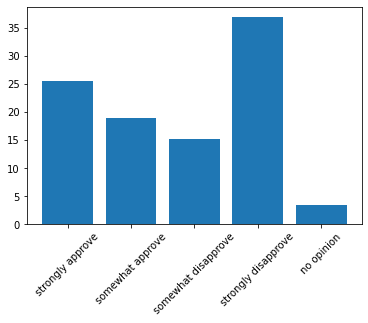

In [319]:
a = np.histogram(storage[0, 1, :])[0]
plt.bar(approval_types, a[a.nonzero()]/10)
plt.xticks(rotation=45)
plt.show()

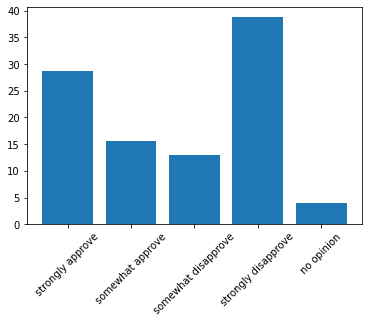

In [310]:
for i in range(len(storage)):
    clear_output(wait=True)
    a = np.histogram(storage[i, 1, :])[0]
    plt.bar(approval_types, a[a.nonzero()]/10)
    plt.xticks(rotation=45)
    plt.show()

## Optimize

In [30]:
'''MULTIPLE RUNS'''
media_names = [m.name for m in media_outlets]
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

    
#first period
late_night_jokes = 4.202088452088452
coverage_leaning = 0.05

target = [42, 52, 6]
bounds = [(0, 1.5), (0, 1.5), (0, 1.5), (0, 1.5), (-0.2, 0)]
initial_guess = [0, 0, 0, 0, 0]#[ 0.17344969,  0.01209804,  0.28695447,  0.04543561, -0.0018641986]
iters = 10
def f(x):
    (threshold, alpha, persuadability_scale, social_media_const, late_night_const) = x
    losses = np.zeros((iters,))
    for i in range(iters):
        m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)

        steps = 30
        starting_state = m.starting_state.copy()
        num_agents = len(m.agents)
        
        approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
        

        media_choices = np.zeros((num_agents, steps))
        media_contributions = np.zeros((num_agents, steps))
        agent_approvals = []
        consumption_rates = np.zeros((num_agents, ))
        uses_social_media = []
        agent_late_night = []
        neg_persuadability = np.zeros((num_agents,))
        pos_persuadability = np.zeros((num_agents,))
        agent_anti_late_night = []

        denom = np.exp(2)-1
        for i, agent in enumerate(m.agents):
            agent_approvals.append(agent.approval)
            consumption_rates[i] = agent.consumption_rate
            uses_social_media.append(agent.uses_social_media)
            agent_late_night.append(agent.late_night)
            agent_anti_late_night.append(agent.anti_late_night)
            neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
            pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
            if len(agent.consume_media()) == 0:
                media_choices[i] = np.array([None]*steps)
                media_contributions[i] = np.array([None]*steps)
            else:
                #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
                sources = np.array(agent.assigned_media_sources)
                values = np.array(agent.consume_media())
                choices = np.random.randint(0, len(sources), (steps,))
                media_choices[i] = values[choices]



                media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]

        result, _, _ = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), 
                      np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                      threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                      late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)

        result = result[-1]
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - target[i])**2
        loss /= len(result)
        losses[i] = loss
        print(f"\r Loss: {loss:.4f}", end=' ', flush=True)
#     mean = np.mean(losses)
#     var = np.var(losses)
#     print(f'\r Mean: {mean}, Variance: {var}, Sum: {np.sum(losses)}', end=' ', flush=True)
    return np.mean(losses)

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=15)
opt

 Loss: 22.1050    differential_evolution step 1: f(x)= 0.013
 Loss: 1.4600 0 differential_evolution step 2: f(x)= 0.0045
 Loss: 45.9650  differential_evolution step 3: f(x)= 0.0045
 Loss: 1.4600   differential_evolution step 4: f(x)= 0.0045
 Loss: 0.3250   differential_evolution step 5: f(x)= 0.0045
 Loss: 17.4100 differential_evolution step 6: f(x)= 0.0045
 Loss: 19.9400  differential_evolution step 7: f(x)= 0.001
 Loss: 0.9700  differential_evolution step 8: f(x)= 0.0005
 Loss: 0.9050  differential_evolution step 9: f(x)= 0.0005
 Loss: 0.5200  differential_evolution step 10: f(x)= 0.0005
 Loss: 1.1650  differential_evolution step 11: f(x)= 0.0005
 Loss: 0.8000  differential_evolution step 12: f(x)= 0.0005
 Loss: 0.0800  differential_evolution step 13: f(x)= 0.0005
 Loss: 0.6100  differential_evolution step 14: f(x)= 0.0005
 Loss: 0.1000  differential_evolution step 15: f(x)= 0.0005
 Loss: 0.6500 

     fun: 0.0005000000000000142
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1308
     nit: 15
 success: False
       x: array([ 0.35488834,  0.05845358,  0.77660642,  1.46825063, -0.00885636])

# Late Night

In [35]:
(threshold, alpha, persuadability_scale, social_media_const, late_night_const) = opt.x#[ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]#
args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)

samples = 100
steps = 30

LN_period1 = np.zeros((samples, steps, 2))
LN_period2 = np.zeros((samples, steps, 2))
print('Gathering Samples...')
print('\r[' + '>' + '-'*19 + ']', end=' ', flush=True)

total_media_contributions = np.zeros((27, ))
for k in range(samples):
    temp = int(k // (samples/20))
    if temp == 0: temp = 1
    print('\r[' + '='*(temp-1) + '>' + '-'*(20-temp) + ']', end=' ', flush=True)
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=True)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    media_contributions = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))
    agent_anti_late_night = []

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        agent_anti_late_night.append(agent.anti_late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
            media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]

    agent_approvals = np.array(agent_approvals)
    late_night_jokes = 4.202088452088452
    coverage_leaning = 0.05
    LN_period1[k], media_array, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), 
                  np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)
    
    total_media_contributions += media_array
    
    for i, agent in enumerate(m.agents):

        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
            media_contributions[i] = [media_names.index(m.name) for m in sources[choices]]

            
    late_night_jokes = 4.8740165631469985
    coverage_leaning = -0.25

    LN_period2[k], media_array, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), 
                  np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=True, contributions=media_contributions)

    total_media_contributions += media_array

Gathering Samples...
[==================>-] 

 Mean Approval Error: 1.6041666666666665
 Mean Disapproval Error: 1.3516666666666666
 Approval Std: 0.9231917003285696
 Disapproval Std: 0.7560618662223056


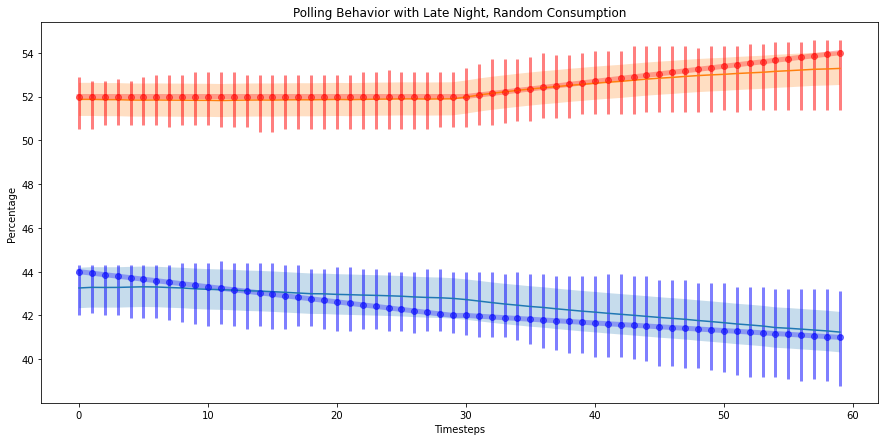

In [36]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(LN_period1, axis=0), np.mean(LN_period2, axis=0)))
approval = np.concatenate((LN_period1[:, :, 0], LN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((LN_period1[:, :, 1], LN_period2[:, :, 1]), axis=1)

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


maxes = np.max(approval, axis=0)
mins = np.min(approval, axis=0)
app_err = [ipsos_app-mins, maxes-ipsos_app]
plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='o', color='blue',
             ecolor='blue', elinewidth=3, capsize=0, alpha=0.5)


maxes = np.max(disapproval, axis=0)
mins = np.min(disapproval, axis=0)
dis_err = [ipsos_dis-mins, maxes-ipsos_dis]

plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='o', color='red',
             ecolor='red', elinewidth=3, capsize=0, alpha=0.5)

app_mean = np.mean(approval, axis=0)
plt.plot(steps, app_mean)
app_std = np.std(approval)
plt.fill_between(steps, app_mean-app_std, app_mean+app_std, alpha=0.25)

dis_mean = np.mean(disapproval, axis=0)
plt.plot(steps, dis_mean)
dis_std = np.std(disapproval)
plt.fill_between(steps, dis_mean-dis_std, dis_mean+dis_std, alpha=0.25)

print(f' Mean Approval Error: {np.mean(app_err)}\n Mean Disapproval Error: {np.mean(dis_err)}')
print(f' Approval Std: {app_std}\n Disapproval Std: {dis_std}')

<ErrorbarContainer object of 3 artists>

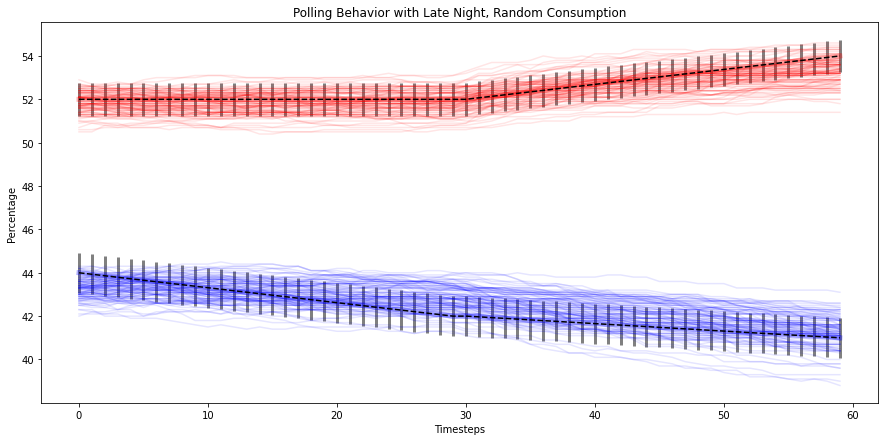

In [37]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior with Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((LN_period1, LN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='-',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='-',color='red', alpha=0.1)

plt.errorbar(steps, ipsos_app, yerr=app_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
plt.errorbar(steps, ipsos_dis, yerr=dis_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)

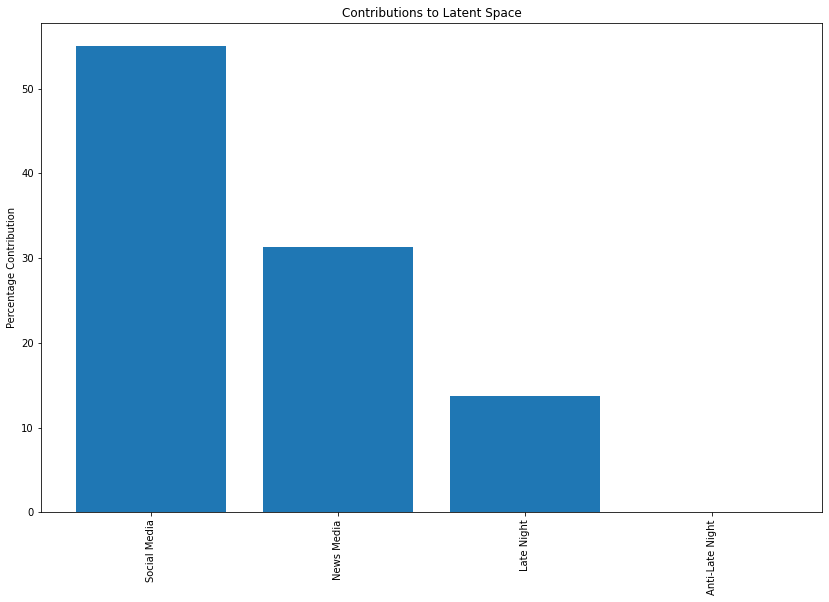

In [38]:
plt.figure(figsize=(14, 9))
media_array = np.abs(np.concatenate((np.array(np.sum(total_media_contributions[:-3])).reshape(-1, ), total_media_contributions[-3:])))
media_array = media_array/np.sum(media_array)
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(['News Media', 'Anti-Late Night', 'Late Night', 'Social Media'])#media_names+['Anti-Late Night', 'Late Night', 'Social Media'])
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

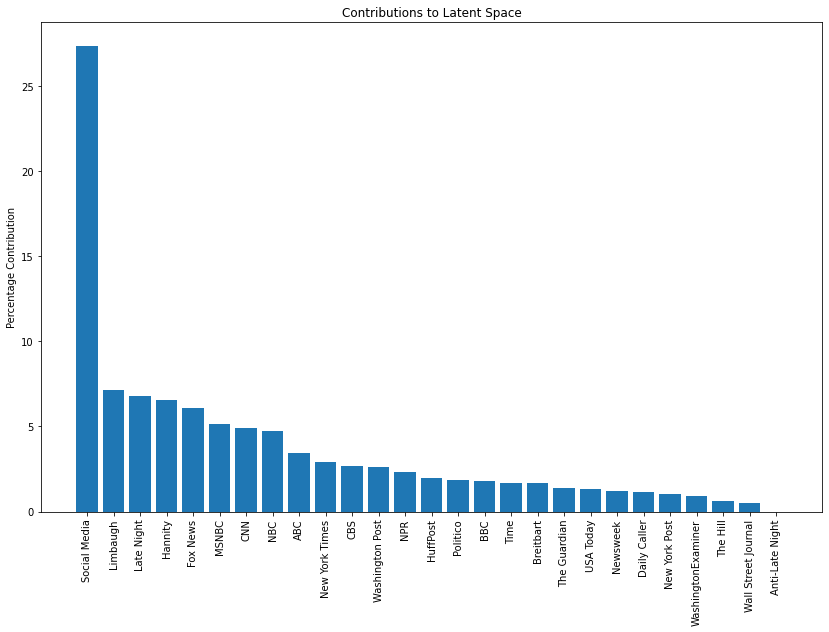

In [39]:
plt.figure(figsize=(14, 9))
media_array = np.abs(total_media_contributions)
media_array = media_array/np.sum(media_array)
args = np.argsort(media_array)[::-1]
plt.bar(range(len(media_array)), media_array[args]*100)
labels = np.array(media_names+['Anti-Late Night', 'Late Night', 'Social Media'])
plt.xticks((range(len(labels))), labels=labels[args], rotation='vertical')
plt.ylabel('Percentage Contribution')
plt.title('Contributions to Latent Space')
plt.show()

# No Late Night

In [40]:
'''MULTIPLE RUNS'''

args = (1000, [44, 37, 10],
            [[5, 56, 14],
            [8, 30, 23],
            [18, 7, 21],
            [67, 5, 32],
            [2, 1, 10]], media_outlets)
coverage_leaning = 0.05
    
#first period
late_night_jokes = 4.202088452088452
late_night_const=0

target = [42, 52, 6]
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
initial_guess = [0.23464376, 0.01751634, 0.27036223, 0.01610636]
iters = 10
def f(x):
    (threshold, alpha, persuadability_scale, social_media_const) = x
    losses = np.zeros((iters,))
    for i in range(iters):
        m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)

        steps = 30
        starting_state = m.starting_state.copy()
        num_agents = len(m.agents)
        
        approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])
        

        media_choices = np.zeros((num_agents, steps))
        media_contributions = np.zeros((num_agents, steps))
        agent_approvals = []
        consumption_rates = np.zeros((num_agents, ))
        uses_social_media = []
        agent_late_night = []
        neg_persuadability = np.zeros((num_agents,))
        pos_persuadability = np.zeros((num_agents,))
        agent_anti_late_night = []

        denom = np.exp(2)-1
        for i, agent in enumerate(m.agents):
            agent_approvals.append(agent.approval)
            consumption_rates[i] = agent.consumption_rate
            uses_social_media.append(agent.uses_social_media)
            agent_late_night.append(agent.late_night)
            agent_anti_late_night.append(agent.anti_late_night)
            neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
            pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
            if len(agent.consume_media()) == 0:
                media_choices[i] = np.array([None]*steps)
                media_contributions[i] = np.array([None]*steps)
            else:
                #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
                sources = np.array(agent.assigned_media_sources)
                values = np.array(agent.consume_media())
                choices = np.random.randint(0, len(sources), (steps,))
                media_choices[i] = values[choices]

#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])

        result, _, _ = optimize_step(steps, starting_state, num_agents, np.array(agent_approvals), consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                      threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                      late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

        result = result[-1]
        loss = 0
        for i in range(len(result)):
            loss += abs(result[i] - target[i])**2
        loss /= len(result)
        losses[i] = loss
        print(f"\r Loss: {loss:.4f}", end=' ', flush=True)
#     mean = np.mean(losses)
#     var = np.var(losses)
#     print(f'\r Mean: {mean}, Variance: {var}', end=' ', flush=True)
    return np.sum(losses)

opt = differential_evolution(f, bounds, strategy='best1bin', disp=True, maxiter=15)
opt

 Loss: 3.0650    differential_evolution step 1: f(x)= 0.25
 Loss: 0.7450   differential_evolution step 2: f(x)= 0.125
 Loss: 3.8600    differential_evolution step 3: f(x)= 0.125
 Loss: 9.5400   differential_evolution step 4: f(x)= 0.085
 Loss: 17.4100 differential_evolution step 5: f(x)= 0.04
 Loss: 4.5250  differential_evolution step 6: f(x)= 0.04
 Loss: 2.9800  differential_evolution step 7: f(x)= 0.025
 Loss: 13.8850 differential_evolution step 8: f(x)= 0.025
 Loss: 1.1650  differential_evolution step 9: f(x)= 0.025
 Loss: 1.1050   differential_evolution step 10: f(x)= 0.025
 Loss: 7.3000  differential_evolution step 11: f(x)= 0.02
 Loss: 0.0850   differential_evolution step 12: f(x)= 0.02
 Loss: 1.3050  differential_evolution step 13: f(x)= 0.01
 Loss: 0.5050    differential_evolution step 14: f(x)= 0.005
 Loss: 0.0900  differential_evolution step 15: f(x)= 0
 Loss: 0.6250 

     fun: 0.0
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1020
     nit: 15
 success: False
       x: array([0.33410952, 0.13099857, 0.61478907, 0.66126245])

In [43]:
(threshold, alpha, persuadability_scale, social_media_const) = opt.x#[0.24866063, 0.0122411 , 0.48779229, 0.4282044 , 0]#[ 0.17344969,  0.01209804,  0.28695447,  0.04543561, 0]#opt.x#[ 0.13944413,  0.06975399,  0.22779948,  0.95373104, -0.56726164]#
late_night_const = 0
samples = 1000
steps = 30

NLN_period1 = np.zeros((samples, steps, 2))
NLN_period2 = np.zeros((samples, steps, 2))
print('Gathering Samples...')
print('\r[' + '>' + '-'*19 + ']', end=' ', flush=True)
for k in range(samples):
    temp = int(k // (samples/20))
    if temp == 0: temp = 1
    print('\r[' + '='*(temp-1) + '>' + '-'*(20-temp) + ']', end=' ', flush=True)
    m = Model(*args, distribution_threshold=0.5,  platform_split=[[6+15+13+29, 19], [8+13+18+26, 15]], use_late_night=False)


    steps = 30
    starting_state = m.starting_state.copy()
    num_agents = len(m.agents)

    approval_types = np.array(['strongly approve', 'somewhat approve', 'somewhat disapprove', 'strongly disapprove', 'no opinion'])


    media_choices = np.zeros((num_agents, steps))
    media_contributions = np.zeros((num_agents, steps))
    agent_approvals = []
    consumption_rates = np.zeros((num_agents, ))
    uses_social_media = []
    agent_late_night = []
    neg_persuadability = np.zeros((num_agents,))
    pos_persuadability = np.zeros((num_agents,))
    agent_anti_late_night = []

    denom = np.exp(2)-1
    for i, agent in enumerate(m.agents):
        agent_approvals.append(agent.approval)
        consumption_rates[i] = agent.consumption_rate
        uses_social_media.append(agent.uses_social_media)
        agent_late_night.append(agent.late_night)
        agent_anti_late_night.append(agent.anti_late_night)
        neg_persuadability[i] = (np.exp(-starting_state[i]+1)-1)/denom
        pos_persuadability[i] = (np.exp(starting_state[i]+1)-1)/denom
        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
            media_contributions[i] = np.array([None]*steps)
        else:
            #the contibution array will just have the 27 sources as 0s, and we will give the optimize step a list the same size as media choices that just has the index that the contribution should go to
            sources = np.array(agent.assigned_media_sources)
            values = np.array(agent.consume_media())
            choices = np.random.randint(0, len(sources), (steps,))
            media_choices[i] = values[choices]
#         uses_social_media = np.array([agent.uses_social_media for agent in m.agents])

#         agent_late_night = np.array([agent.late_night for agent in m.agents])
    
    late_night_jokes = 4.202088452088452
    coverage_leaning = 0.05
    agent_approvals = np.array(agent_approvals)
    NLN_period1[k], _, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

    
    for i, agent in enumerate(m.agents):

        if len(agent.consume_media()) == 0:
            media_choices[i] = np.array([None]*steps)
        else:
            media_choices[i] = np.random.choice(agent.consume_media(), (steps,))
            
    late_night_jokes = 4.8740165631469985
    coverage_leaning = -0.25

    NLN_period2[k], _, _ = optimize_step(steps, starting_state, num_agents, agent_approvals, consumption_rates, media_choices, np.array(uses_social_media), np.array(agent_late_night), np.array(agent_anti_late_night), approval_types, neg_persuadability, pos_persuadability, 
                  threshold=threshold, alpha=alpha, persuadability_scale=persuadability_scale, coverage_leaning=coverage_leaning, social_media_const=social_media_const, 
                  late_night_const=late_night_const, late_night_jokes=late_night_jokes, use_late_night=False, contributions=media_contributions)

Gathering Samples...
[==================>-] 

 Mean Approval Error: 2.1249999999999996
 Mean Disapproval Error: 1.8775
 Approval Std: 1.2126288842153372
 Disapproval Std: 1.007349587509498


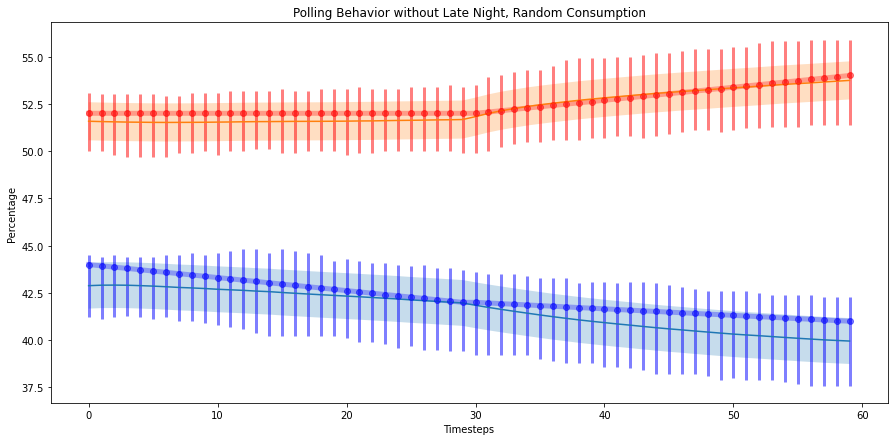

In [44]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
means = np.concatenate((np.mean(NLN_period1, axis=0), np.mean(NLN_period2, axis=0)))
approval = np.concatenate((NLN_period1[:, :, 0], NLN_period2[:, :, 0]), axis=1)
disapproval = np.concatenate((NLN_period1[:, :, 1], NLN_period2[:, :, 1]), axis=1)

plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)


maxes = np.max(approval, axis=0)
mins = np.min(approval, axis=0)
app_err = [ipsos_app-mins, maxes-ipsos_app]
plt.errorbar(steps, ipsos_app, yerr=app_err, fmt='o', color='blue',
             ecolor='blue', elinewidth=3, capsize=0, alpha=0.5)


maxes = np.max(disapproval, axis=0)
mins = np.min(disapproval, axis=0)
dis_err = [ipsos_dis-mins, maxes-ipsos_dis]

plt.errorbar(steps, ipsos_dis, yerr=dis_err, fmt='o', color='red',
             ecolor='red', elinewidth=3, capsize=0, alpha=0.5)

app_mean = np.mean(approval, axis=0)
plt.plot(steps, app_mean)
app_std = np.std(approval)
plt.fill_between(steps, app_mean-app_std, app_mean+app_std, alpha=0.25)

dis_mean = np.mean(disapproval, axis=0)
plt.plot(steps, dis_mean)
dis_std = np.std(disapproval)
plt.fill_between(steps, dis_mean-dis_std, dis_mean+dis_std, alpha=0.25)

print(f' Mean Approval Error: {np.mean(app_err)}\n Mean Disapproval Error: {np.mean(dis_err)}')
print(f' Approval Std: {app_std}\n Disapproval Std: {dis_std}')

<ErrorbarContainer object of 3 artists>

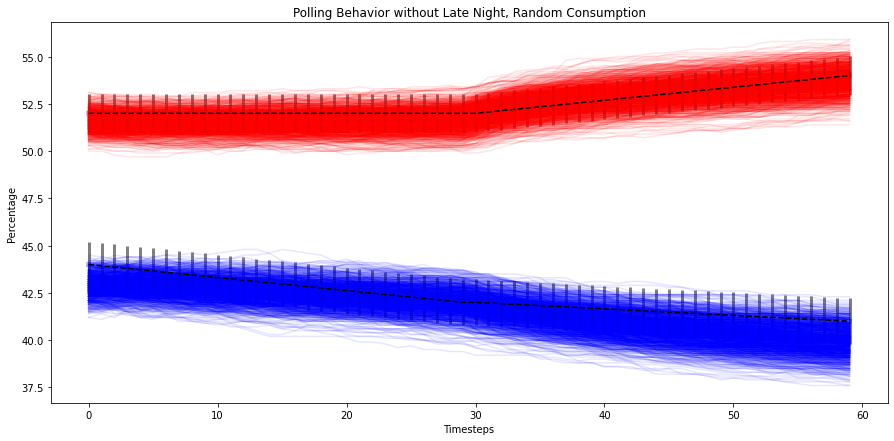

In [45]:
steps = range(60)

fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
plt.title("Polling Behavior without Late Night, Random Consumption")
plt.xlabel("Timesteps")
plt.ylabel("Percentage")



ipsos_app = np.concatenate((np.linspace(44, 42, 30), np.linspace(42, 41, 30)))
ipsos_dis = np.concatenate((np.linspace(52, 52, 30), np.linspace(52, 54, 30)))
both = np.concatenate((NLN_period1, NLN_period2), axis=1)
plt.plot(steps, ipsos_app, label='Ipsos Approval Trend Line', color='blue', lw=5, alpha=0.3)
plt.plot(steps, ipsos_dis, label='Ipsos Disapproval Trend Line', color='red', lw=5, alpha=0.3)
for i, run in enumerate(both):


    ax.plot(steps, run[:, 0], label="Simulated Approval", linestyle='-',color='blue', alpha=0.1)
    ax.plot(steps, run[:, 1], label="Simulated Disapproval", linestyle='-',color='red', alpha=0.1)

plt.errorbar(steps, ipsos_app, yerr=app_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)
plt.errorbar(steps, ipsos_dis, yerr=dis_std, fmt='--', color='black',
             ecolor='gray', elinewidth=3, capsize=0)

In [37]:
LN_period1[-1][0], LN_period2[0][0]

(array([43.7, 52.9]), array([41.7, 52.7]))

In [61]:
def estimate(t, x0, p, alpha, M, cl):
    f = np.math.factorial
    binom = 0
    expansion = 0
    for n in range(0, t+1):
        binom += f(t)*((-1)**(n)) * ((alpha * p)**n) / (f(n) * f(t-n))
        expansion += ((-1)**(n))*(t-n)*((alpha*p)**(n+1))*(M+cl)
    x = (binom)*x0 + expansion
    return x if not np.isnan(x) else 0
    
w = np.where([not model.agents[i].uses_social_media for i in range(len(model.agents))])

media_means = [np.mean(model.agents[i].consume_media()) for i in range(len(model.agents))]
alpha = 0.06361854
p = [abs(-np.sign(media_choices[i])- model.starting_state[i])/2 for i in range(len(model.agents))]

est_approval = np.array([estimate(30, model.starting_state[i], p[i], alpha, media_means[i], 0) for i in range(len(model.agents))])
plt.scatter(model.agent_approval_values[w], est_approval[w])
plt.show()

print(np.mean(abs(model.agent_approval_values[w] - est_approval[w])))
print(np.corrcoef(model.agent_approval_values[w], est_approval[w])[0][1])


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''